## Compare ACCESS-OM2-1 and ACCESS-OM2-025 

###### ISSUES:
- ACCESS-OM2-1 missing mixing terms -- need to re-run
- both only 1 year daily data (and haven't got 10 year daily 1 deg output yet)

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=8)
client

2022-11-16 12:03:41,058 - distributed.diskutils - INFO - Found stale lock file and directory '/g/data/e14/cy8964/analysis/usyd/Overturning_decomposition/Paper-Code/dask-worker-space/worker-tj10oyj2', purging
2022-11-16 12:03:41,066 - distributed.diskutils - INFO - Found stale lock file and directory '/g/data/e14/cy8964/analysis/usyd/Overturning_decomposition/Paper-Code/dask-worker-space/worker-d4yijh94', purging
2022-11-16 12:03:41,073 - distributed.diskutils - INFO - Found stale lock file and directory '/g/data/e14/cy8964/analysis/usyd/Overturning_decomposition/Paper-Code/dask-worker-space/worker-r3_hh1jc', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41323,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:35889,Total threads: 2
Dashboard: /proxy/43731/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:44503,


In [4]:
# files:
base = '/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/';
xch = 1440#2*288
ych = 1080#2*216

fgrd   = xr.open_dataset(base + 'output096/ocean/ocean_grid.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch,'xu_ocean':xch})
fwmass_mean = xr.open_mfdataset('/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/output096-105_mean/ocean_wmass_mean.nc').chunk({'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch})
fmonth_mean = xr.open_mfdataset('/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/output096-105_mean/ocean_month_mean.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch})
fheat_mean = xr.open_mfdataset('/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/output096-105_mean/ocean_heat_mean.nc').chunk({'yt_ocean':ych,'xt_ocean':xch})

# load RYF monthly data
base_msc = '/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fmonth_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_month.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_heat.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_wmass.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# load RYF daily data
base_msc = '/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fdaily = xr.open_mfdataset(base_msc+'output096/ocean/ocean_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_daily = xr.open_mfdataset(base_msc+'output096/ocean/ocean_heat_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_daily = xr.open_mfdataset(base_msc+'output096/ocean/ocean_wmass_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm = Grid(fwmass_m,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn = Grid(fmonth_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht = Grid(fheat_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridd = Grid(fdaily,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
grid2 = Grid(fgrd,coords={"x":{"center":"xt_ocean","right":"xu_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"}},periodic=False)

# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_m.neutral[1]-fwmass_m.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})
dx = grid2.diff(fgrd.xu_ocean,'x',boundary='extend').rename({'xt_ocean':'grid_xt_ocean'})

In [5]:
# Quarter degree (x,y,temp) datasets

True_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/True_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/Mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Twomo_mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/2mo_mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
sc_Twomo_mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/sc_2mo_mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Tenday_mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/10day_mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Oneday_mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/1day_mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})


In [6]:
# files:
base = '/g/data/hh5/tmp/cy8964/access-om2/archive/1deg_jra55_ryf/';
xch = 360#2*288
ych = 240#2*216

fgrd1   = xr.open_dataset(base + 'output101/ocean/ocean_grid.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10,'xu_ocean':xch/10})
fwmass_mean1 = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_101/ocean_wmass_mean.nc').chunk({'grid_yt_ocean':ych/10,'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})
fmonth_mean1 = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_101/ocean_month_mean.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10})
fheat_mean1 = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_101/ocean_heat_mean.nc').chunk({'yt_ocean':ych/10,'xt_ocean':xch/10})

# load RYF monthly data
base_msc = '/g/data/hh5/tmp/cy8964/access-om2/archive/1deg_jra55_ryf/output101/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fmonth_m1 = xr.open_mfdataset(base_msc+'ocean/ocean_month.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_m1 = xr.open_mfdataset(base_msc+'ocean/ocean_heat.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_m1 = xr.open_mfdataset(base_msc+'ocean/ocean_wmass.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# load RYF daily data
base_msc = '/g/data/hh5/tmp/cy8964/access-om2/archive/1deg_jra55_ryf/output101/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fdaily1 = xr.open_mfdataset(base_msc+'ocean/ocean_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_daily1 = xr.open_mfdataset(base_msc+'ocean/ocean_heat_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_daily1 = xr.open_mfdataset(base_msc+'ocean/ocean_wmass_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm1 = Grid(fwmass_m1,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn1 = Grid(fmonth_m1,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht1 = Grid(fheat_m1,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridd1 = Grid(fdaily1,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)

# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT1 = (fwmass_m1.neutral[1]-fwmass_m1.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area1 = fgrd1.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy1 = gridmn1.diff(fgrd1.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})
grid21 = Grid(fgrd1,coords={"x":{"center":"xt_ocean","right":"xu_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"}},periodic=False)
dx1 = grid21.diff(fgrd1.xu_ocean,'x',boundary='extend').rename({'xt_ocean':'grid_xt_ocean'})
dyt1 = gridmn1.diff(fgrd1.yu_ocean,'y',boundary='extend')
dxt1 = grid21.diff(fgrd1.xu_ocean,'x',boundary='extend')

## Quarter Degree Zonal Means

In [7]:
# masking:
maskPsi = 0*True_10year_means.Psi.sum('grid_xt_ocean').where(True_10year_means.Psi.sum('grid_xt_ocean')!=True_10year_means.Psi.sum('grid_xt_ocean').isel(neutralrho_edges=-1))+1.
maskHf = gridwm.interp(maskPsi,'T')
maskSF = gridwm.interp(maskPsi,'y',boundary="fill",fill_value=0.)
maskSF

<xarray.DataArray 'mul-b7cbe726caf7dd7f32980cca34702a46' (neutralrho_edges: 75,
                                                          grid_yt_ocean: 1080)>
dask.array<mul, shape=(75, 1080), dtype=float64, chunksize=(75, 1079), chunktype=numpy.ndarray>
Coordinates:
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0
  * grid_yt_ocean     (grid_yt_ocean) float64 -81.08 -80.97 ... 89.84 89.95

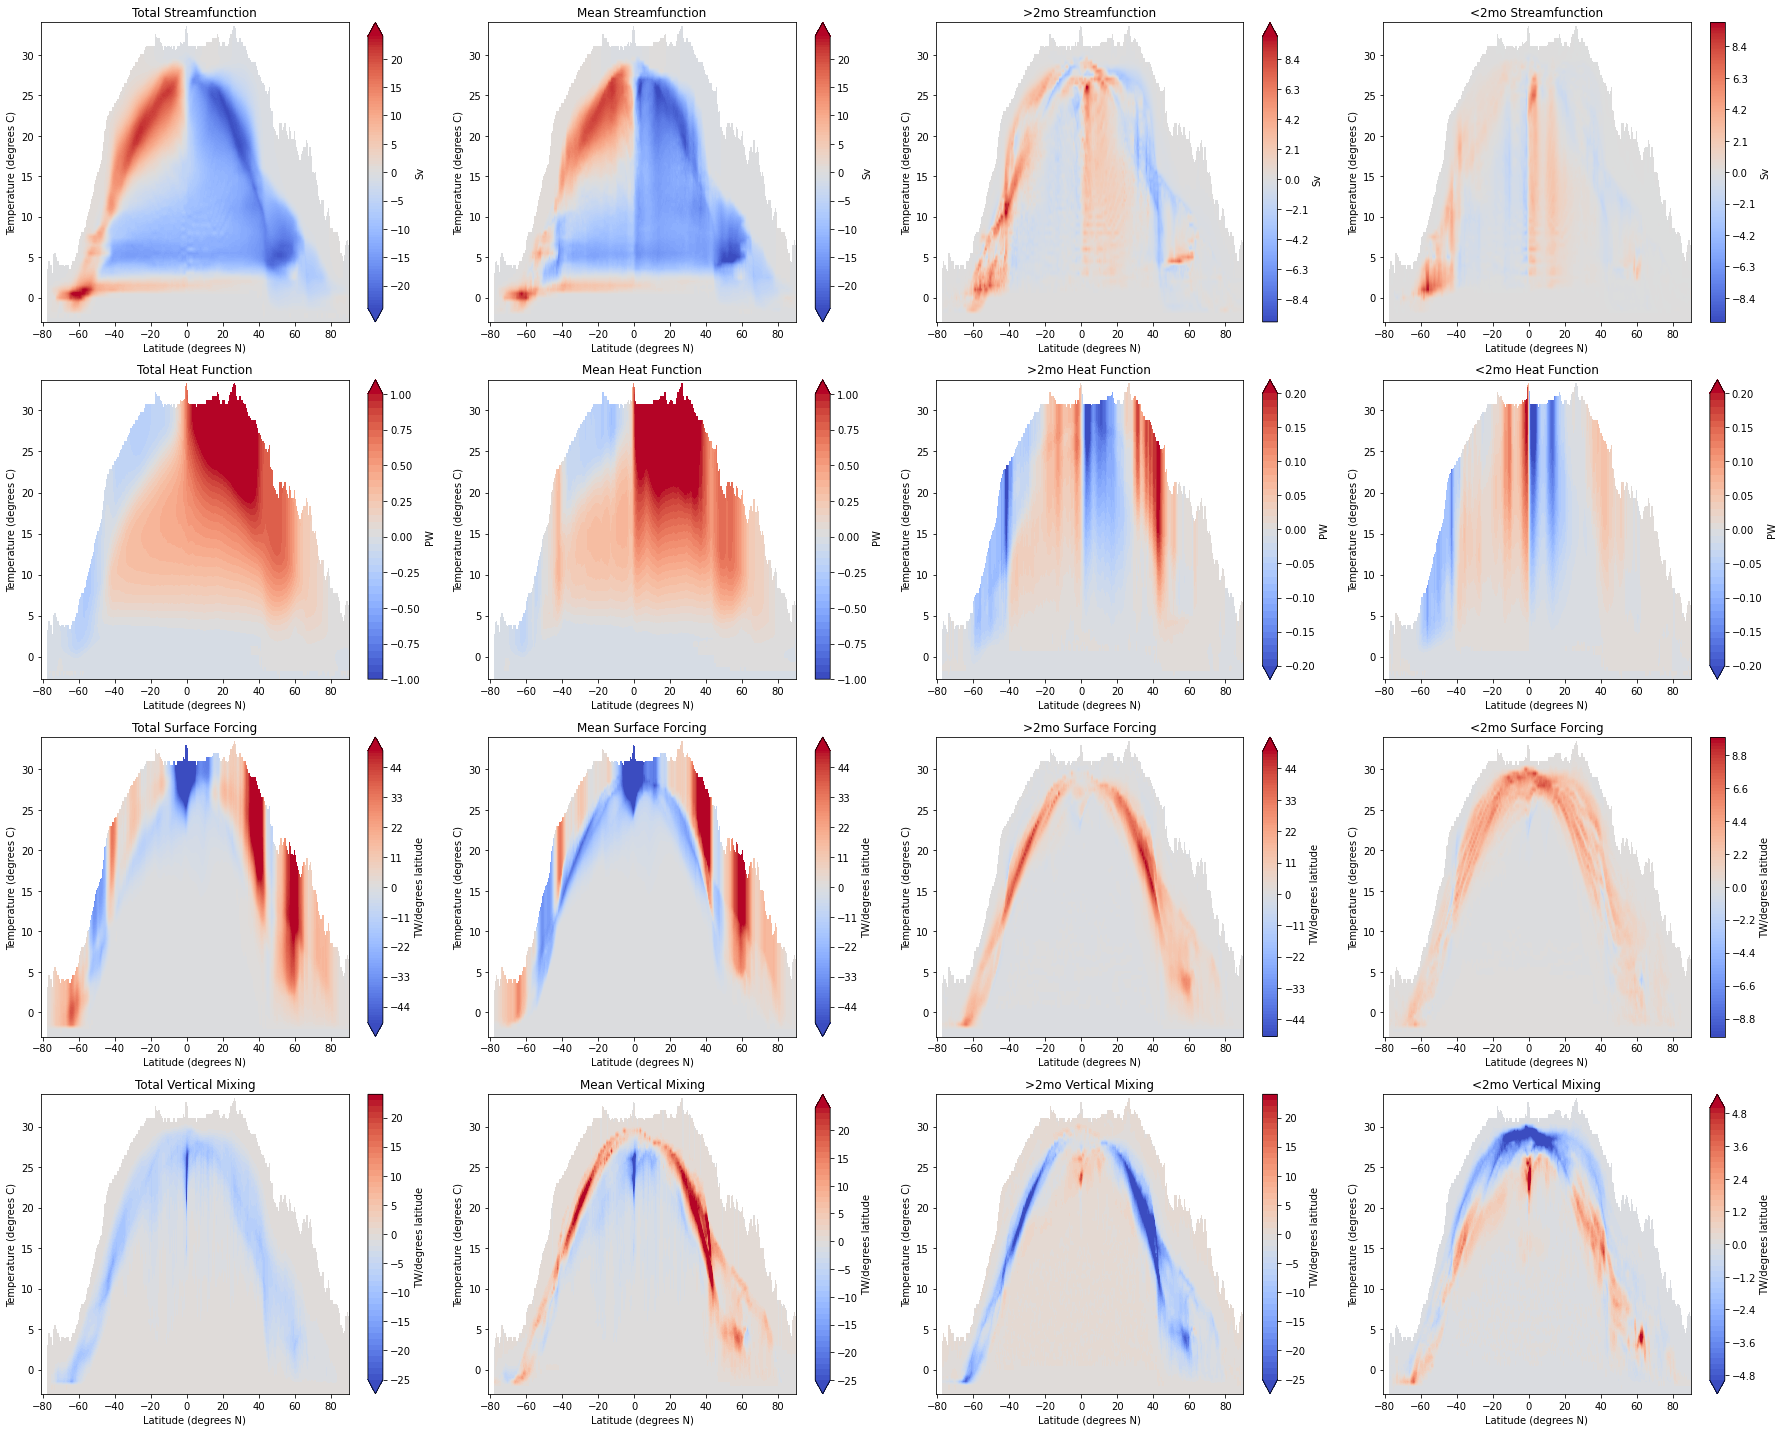

In [8]:
# Plotting:
plt.figure(figsize=(25,20),facecolor='w')

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

cmap = 'coolwarm'

# Saturated bars for the seasonal/eddy terms:
sat = True
if (sat):
    Psicbar_sc = np.arange(-10.,10.1,0.1)
    Hfcbar_sc = np.arange(-0.2,0.21,0.01)
    SFcbar_sc = np.arange(-50.,51.,1.)
    MXcbar_sc = np.arange(-25.,25.,1.)
    Psicbar_e = np.arange(-10.,10.1,0.1)
    Hfcbar_e = np.arange(-0.2,0.21,0.01)
    SFcbar_e = np.arange(-10.,10.2,0.2)
    MXcbar_e = np.arange(-5.,5.2,0.2)
else:
    Psicbar_sc = Psicbar
    Hfcbar_sc = Hfcbar
    SFcbar_sc = SFcbar
    MXcbar_sc = MXcbar
    Psicbar_e = Psicbar
    Hfcbar_e = Hfcbar
    SFcbar_e = SFcbar
    MXcbar_e = MXcbar
    
for i in np.arange(4):
    DataSet = [True_10year_means,Mean_10year_means,Twomo_mean_10year_means - Mean_10year_means,True_10year_means-Twomo_mean_10year_means][i]
    Title = ['Total', 'Mean', '>2mo','<2mo'][i]
    Psicbar_i = [Psicbar, Psicbar, Psicbar_sc, Psicbar_e][i]
    Hfcbar_i = [Hfcbar, Hfcbar, Hfcbar_sc, Hfcbar_e][i]
    SFcbar_i = [SFcbar, SFcbar, SFcbar_sc, SFcbar_e][i]
    MXcbar_i = [MXcbar, MXcbar, MXcbar_sc, MXcbar_e][i]
    
    
    plt.subplot(4,4,i+1)
    (DataSet.Psi.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar_i,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
    plt.title(Title+' Streamfunction')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')
    
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)
    plt.subplot(4,4,i+5)
    (Hf.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar_i,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
    plt.title(Title+' Heat Function')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(4,4,i+9)
    (DataSet.SF.sum('grid_xt_ocean').where(maskSF==1.)/dy/1.e12).plot.contourf(levels=SFcbar_i,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title(Title+' Surface Forcing')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(4,4,i+13)
    (DataSet.MX.sum('grid_xt_ocean').where(maskSF==1.)/dy/1.e12).plot.contourf(levels=MXcbar_i,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title(Title+' Vertical Mixing')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')




plt.tight_layout()

In [9]:
## Define ACCESS-OM2-025 timescales. These are all for 10 years

SF_025 = True_10year_means.SF
SF_mean_tot_025 = Mean_10year_means.SF
SF_ac_025 = (sc_Twomo_mean_10year_means - Mean_10year_means).SF
SF_lt_025 = (Twomo_mean_10year_means - sc_Twomo_mean_10year_means).SF
SF_TIWs_025 = (Tenday_mean_10year_means - Twomo_mean_10year_means).SF
SF_storm_025 = (Oneday_mean_10year_means- Tenday_mean_10year_means).SF
SF_diurnal_025 = (True_10year_means-Oneday_mean_10year_means).SF

MX_025 = True_10year_means.MX
MX_mean_tot_025 = Mean_10year_means.MX
MX_ac_025 = (sc_Twomo_mean_10year_means - Mean_10year_means).MX
MX_lt_025 = (Twomo_mean_10year_means - sc_Twomo_mean_10year_means).MX
MX_TIWs_025 = (Tenday_mean_10year_means - Twomo_mean_10year_means).MX
MX_storm_025 = (Oneday_mean_10year_means- Tenday_mean_10year_means).MX
MX_diurnal_025 = (True_10year_means-Oneday_mean_10year_means).MX


Hf_025 = -Cp*rho0*dT*gridwm.cumsum(True_10year_means.Psi,'T',boundary="fill", fill_value=0)
Hf_mean_tot_025 = -Cp*rho0*dT*gridwm.cumsum(Mean_10year_means.Psi,'T',boundary="fill", fill_value=0)
Hf_ac_025 = -Cp*rho0*dT*gridwm.cumsum((sc_Twomo_mean_10year_means - Mean_10year_means).Psi,'T',boundary="fill", fill_value=0)
Hf_lt_025 = -Cp*rho0*dT*gridwm.cumsum((Twomo_mean_10year_means - sc_Twomo_mean_10year_means).Psi,'T',boundary="fill", fill_value=0)
Hf_TIWs_025 = -Cp*rho0*dT*gridwm.cumsum((Tenday_mean_10year_means - Twomo_mean_10year_means).Psi,'T',boundary="fill", fill_value=0)
Hf_storm_025 = -Cp*rho0*dT*gridwm.cumsum((Oneday_mean_10year_means- Tenday_mean_10year_means).Psi,'T',boundary="fill", fill_value=0)
Hf_diurnal_025 = -Cp*rho0*dT*gridwm.cumsum((True_10year_means-Oneday_mean_10year_means).Psi,'T',boundary="fill", fill_value=0)


# 1 degree zonal means

In [10]:
# One degree (x,y,temp) datasets - stuff which uses daily timescales is only for one year, and is saved in individual files below

True_1year_means_1 = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_101/True_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
Twomo_mean_1year_means_1 = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_101/2mo_mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

Mean_10year_means_1 = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_102_10yr/Mean_10year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
sc_Twomo_10year_means_1 = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_102_10yr/sc_2mo_mean_10year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
True_10year_means_1 = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_102_10yr/True_10year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

path = '/g/data/e14/cy8964/Post_Process/temp/1deg_101/'
path2 = '/g/data/e14/cy8964/Post_Process/temp/1deg_102_10yr/'

SF_10yr_1 = Mean_10year_means_1.SF
SF_2mo_10yr_1 = xr.open_dataarray(path2+'2mo_mean_10year_means_SF_2mo.nc')
SF_sc_10yr_1 = sc_Twomo_10year_means_1.SF
SF_2mo_1 = Twomo_mean_1year_means_1.SF
SF_1 = True_1year_means_1.SF
SF_10day_1 = xr.open_dataarray(path+'10daily_mean_1year_means_SF_10day.nc')
SF_1day_1 = xr.open_dataarray(path+'1daily_mean_1year_means_SF_1day.nc')

MX_10yr_1 = Mean_10year_means_1.MX
MX_2mo_10yr_1 = xr.open_dataarray(path2+'2mo_mean_10year_means_MX_2mo.nc')
MX_sc_10yr_1 = sc_Twomo_10year_means_1.MX
MX_2mo_1 = Twomo_mean_1year_means_1.MX
MX_1day_1= xr.open_dataarray(path+'1daily_mean_1year_means_MX_1day.nc')
MX_10day_1 = xr.open_dataarray(path+'10daily_mean_1year_means_MX_10day.nc')
MX_1 = True_1year_means_1.MX

Psi_2mo_10yr_1 = xr.open_dataarray(path2+'2mo_mean_10year_means_Psi_mean_2mo.nc')
Psi_sc_10yr_1 = sc_Twomo_10year_means_1.Psi
Psi_2mo_1 = Twomo_mean_1year_means_1.Psi
Psi_1day_1= xr.open_dataarray(path+'1daily_mean_1year_means_Psi_mean_1day.nc')
Psi_10day_1 = xr.open_dataarray(path+'10daily_mean_1year_means_Psi_mean_10day.nc')
Psi_1 = True_1year_means_1.Psi




SF_1 = True_10year_means_1.SF
SF_mean_tot_1 = Mean_10year_means_1.SF
SF_ac_1 = SF_sc_10yr_1 - Mean_10year_means_1.SF
SF_lt_1 = SF_2mo_10yr_1 - SF_sc_10yr_1
SF_TIWs_1 = SF_10day_1 - SF_2mo_1 
SF_storm_1 = SF_1day_1 - SF_10day_1
SF_diurnal_1 = SF_1 - SF_1day_1

MX_1 = True_10year_means_1.MX
MX_mean_tot_1 = Mean_10year_means_1.MX
MX_ac_1 = MX_sc_10yr_1 - Mean_10year_means_1.MX
MX_lt_1 = MX_2mo_10yr_1 - MX_sc_10yr_1
MX_TIWs_1 = MX_10day_1 - MX_2mo_1 
MX_storm_1 = MX_1day_1 - MX_10day_1
MX_diurnal_1 = MX_1 - MX_1day_1


Hf_1 = -Cp*rho0*dT*gridwm.cumsum(True_10year_means_1.Psi,'T',boundary="fill", fill_value=0)
Hf_mean_tot_1 = -Cp*rho0*dT*gridwm.cumsum(Mean_10year_means_1.Psi,'T',boundary="fill", fill_value=0)
Hf_ac_1 = -Cp*rho0*dT*gridwm.cumsum((Psi_sc_10yr_1 - Mean_10year_means_1.Psi),'T',boundary="fill", fill_value=0)
Hf_lt_1 = -Cp*rho0*dT*gridwm.cumsum((Psi_2mo_10yr_1 - Psi_sc_10yr_1),'T',boundary="fill", fill_value=0)

Hf_TIWs_1 = -Cp*rho0*dT*gridwm.cumsum((Psi_10day_1 - Psi_2mo_1 ),'T',boundary="fill", fill_value=0)
Hf_storm_1 = -Cp*rho0*dT*gridwm.cumsum((Psi_1day_1 - Psi_10day_1),'T',boundary="fill", fill_value=0)
Hf_diurnal_1 = -Cp*rho0*dT*gridwm.cumsum((Psi_1 - Psi_1day_1),'T',boundary="fill", fill_value=0)


In [11]:
# masking:
maskPsi1 = 0*True_1year_means_1.Psi.sum('grid_xt_ocean').where(True_1year_means_1.Psi.sum('grid_xt_ocean')!=True_1year_means_1.Psi.sum('grid_xt_ocean').isel(neutralrho_edges=-1))+1.
maskHf1 = gridwm1.interp(maskPsi1,'T')
maskSF1 = gridwm1.interp(maskPsi1,'y',boundary="fill",fill_value=0.)
maskSF1

<xarray.DataArray 'mul-b7e1d441cb16ef1e5f17af98125a2202' (neutralrho_edges: 75,
                                                          grid_yt_ocean: 300)>
dask.array<mul, shape=(75, 300), dtype=float64, chunksize=(75, 239), chunktype=numpy.ndarray>
Coordinates:
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0
  * grid_yt_ocean     (grid_yt_ocean) float64 -77.88 -77.63 ... 89.32 89.77

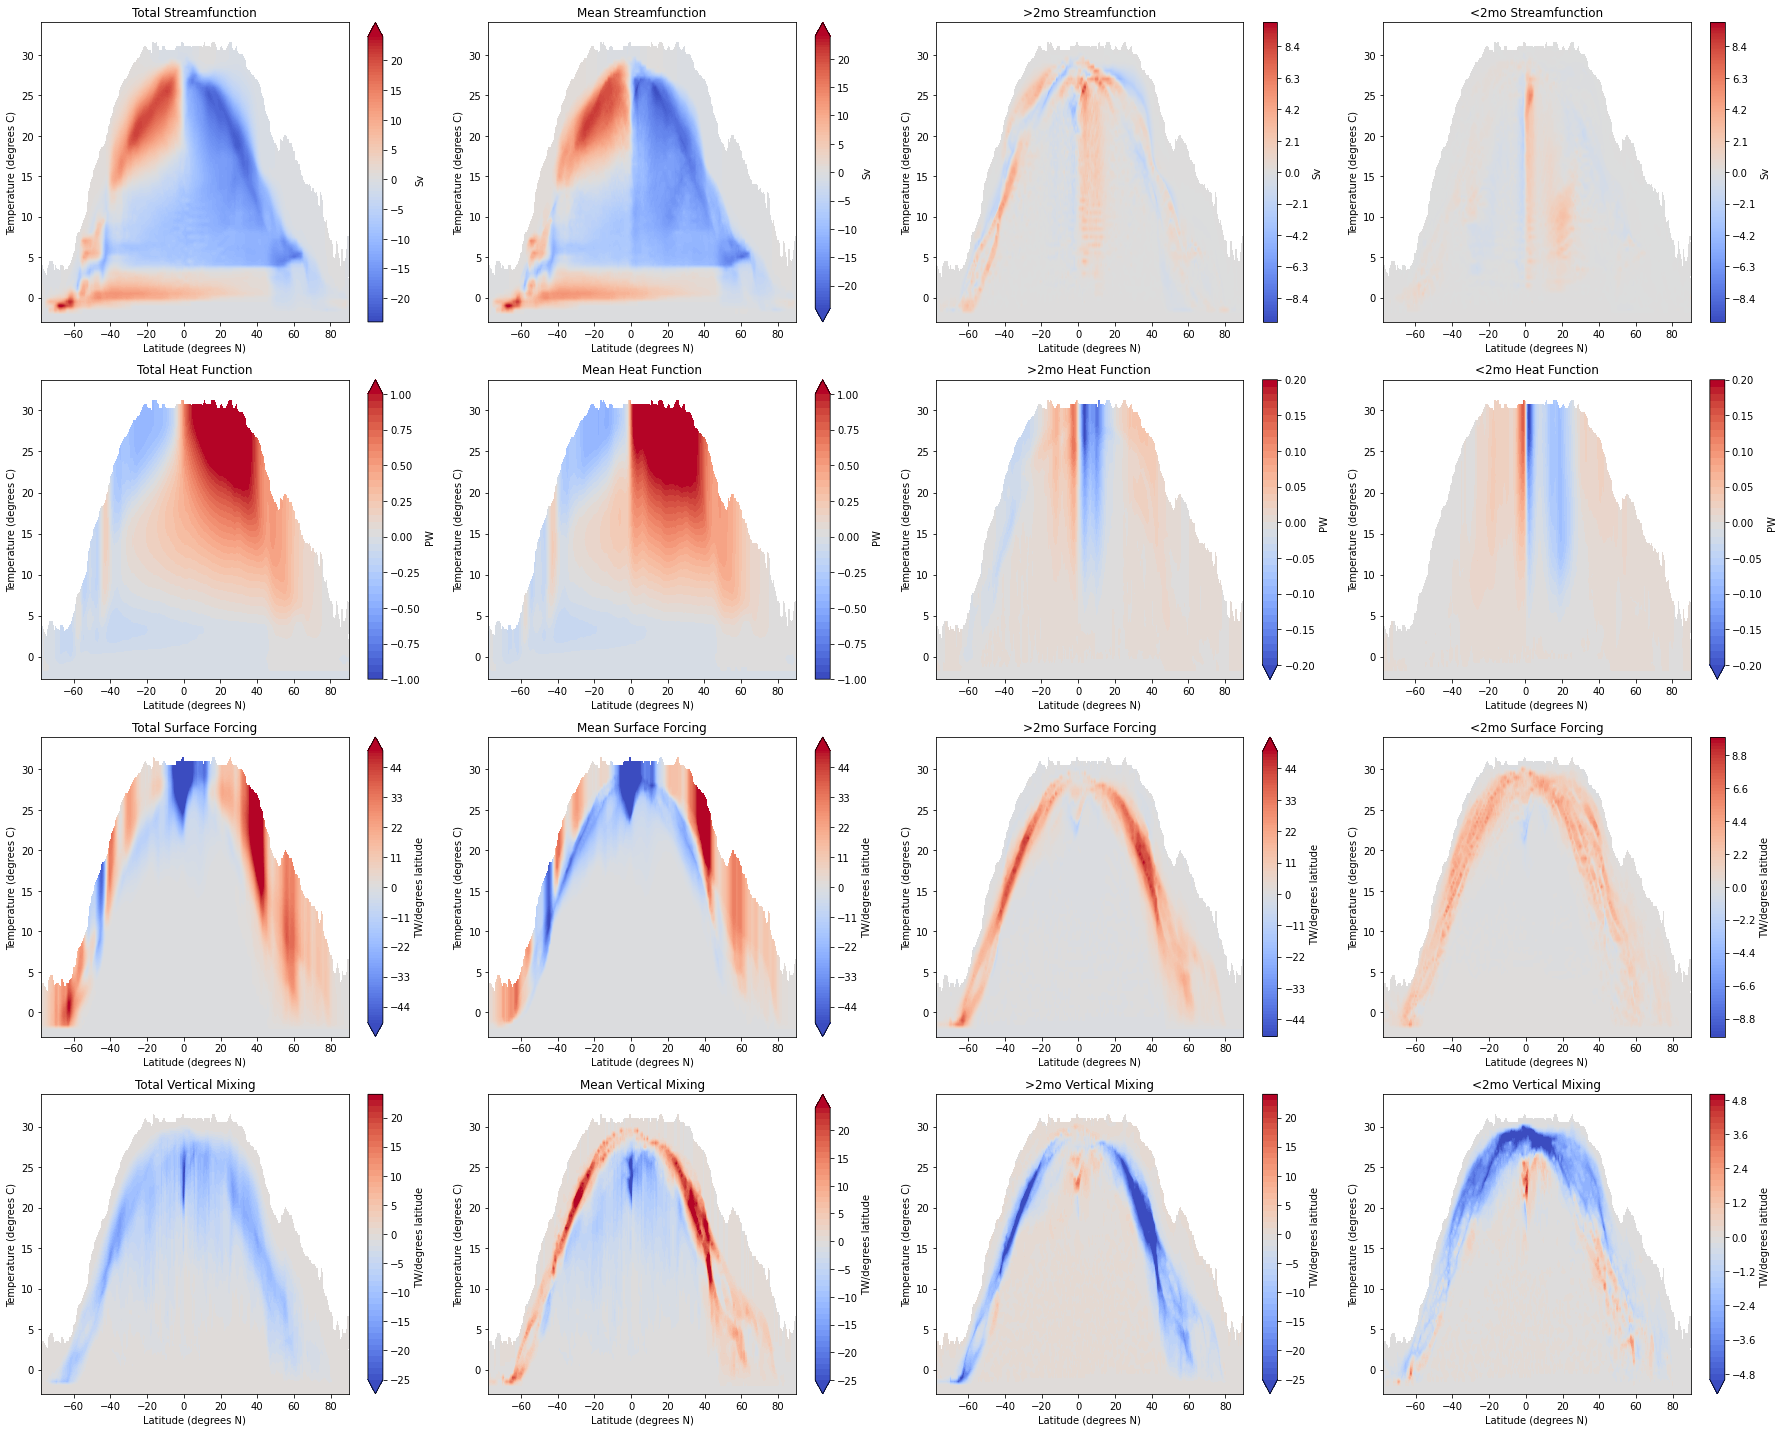

In [12]:
# Plotting:
plt.figure(figsize=(25,20),facecolor='w')

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

cmap = 'coolwarm'

# Saturated bars for the seasonal/eddy terms:
sat = True
if (sat):
    Psicbar_sc = np.arange(-10.,10.1,0.1)
    Hfcbar_sc = np.arange(-0.2,0.21,0.01)
    SFcbar_sc = np.arange(-50.,51.,1.)
    MXcbar_sc = np.arange(-25.,25.,1.)
    Psicbar_e = np.arange(-10.,10.1,0.1)
    Hfcbar_e = np.arange(-0.2,0.21,0.01)
    SFcbar_e = np.arange(-10.,10.2,0.2)
    MXcbar_e = np.arange(-5.,5.2,0.2)
else:
    Psicbar_sc = Psicbar
    Hfcbar_sc = Hfcbar
    SFcbar_sc = SFcbar
    MXcbar_sc = MXcbar
    Psicbar_e = Psicbar
    Hfcbar_e = Hfcbar
    SFcbar_e = SFcbar
    MXcbar_e = MXcbar
    
for i in np.arange(4):
    DataSet = [True_10year_means_1,Mean_10year_means_1,sc_Twomo_10year_means_1 - Mean_10year_means_1,True_10year_means_1-sc_Twomo_10year_means_1][i]
    Title = ['Total', 'Mean', '>2mo','<2mo'][i]
    Psicbar_i = [Psicbar, Psicbar, Psicbar_sc, Psicbar_e][i]
    Hfcbar_i = [Hfcbar, Hfcbar, Hfcbar_sc, Hfcbar_e][i]
    SFcbar_i = [SFcbar, SFcbar, SFcbar_sc, SFcbar_e][i]
    MXcbar_i = [MXcbar, MXcbar, MXcbar_sc, MXcbar_e][i]
    
    
    plt.subplot(4,4,i+1)
    (DataSet.Psi.sum('grid_xt_ocean').where(maskPsi1==1.)/1.e6).plot.contourf(levels=Psicbar_i,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
    plt.title(Title+' Streamfunction')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')
    
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)
    plt.subplot(4,4,i+5)
    (Hf.sum('grid_xt_ocean').where(maskHf1==1.)/1.e15).plot.contourf(levels=Hfcbar_i,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
    plt.title(Title+' Heat Function')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(4,4,i+9)
    (DataSet.SF.sum('grid_xt_ocean').where(maskSF1==1.)/dy1/1.e12).plot.contourf(levels=SFcbar_i,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title(Title+' Surface Forcing')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(4,4,i+13)
    (DataSet.MX.sum('grid_xt_ocean').where(maskSF1==1.)/dy1/1.e12).plot.contourf(levels=MXcbar_i,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title(Title+' Vertical Mixing')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')




plt.tight_layout()

## Now include temperature variance

In [13]:
var_1_10days_mean_025 = xr.open_dataarray('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/1to10day_variance.nc')
var_2mo_mean_025 = xr.open_dataarray('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/10day60day_variance_centered.nc')
var_lt_mean_025 = xr.open_dataarray('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/sc_to_2mo_variance.nc')

var_1_10days_mean_1 = xr.open_dataarray('/g/data/e14/cy8964/Post_Process/temp/1deg_102_10yr/1to10day_variance.nc')
var_2mo_mean_1 = xr.open_dataarray('/g/data/e14/cy8964/Post_Process/temp/1deg_102_10yr/10day60day_variance_centered.nc')
var_lt_mean_1 = xr.open_dataarray('/g/data/e14/cy8964/Post_Process/temp/1deg_102_10yr/sc_to_2mo_variance.nc')


In [14]:
var_2mo_mean_1

<xarray.DataArray 'var_10_60days_mean' (yt_ocean: 300, xt_ocean: 360)>
[108000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    st_ocean  float64 ...
    time      object ...

In [15]:
## zonal means
var_2mo_1 = (var_2mo_mean_1*fgrd1.area_t).sum('xt_ocean')/(fgrd1.area_t).sum('xt_ocean')
var_lt_1 = (var_lt_mean_1*fgrd1.area_t).sum('xt_ocean')/(fgrd1.area_t).sum('xt_ocean')

var_2mo_025 = (var_2mo_mean_025*fgrd.area_t).sum('xt_ocean')/(fgrd.area_t).sum('xt_ocean')
var_lt_025 = (var_lt_mean_025*fgrd.area_t).sum('xt_ocean')/(fgrd.area_t).sum('xt_ocean')


## Load temp_xflux_gm and redi for 1 degree

(Currently a temporary file for one year of data on scratch)

In [17]:
fwmass_1yr1deg = xr.open_mfdataset('/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101/ocean/ocean_wmass.nc').chunk({'grid_yt_ocean':ych/10,'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})


In [27]:
fwmass_1yr1deg.temp_yflux_gm_on_nrho.long_name

'cp*gm_yflux*dxt*rho_dzt*temp binned to neutral density'

In [19]:
## load relevant variables

temp_yflux_gm_on_nrho = fwmass_1yr1deg.temp_yflux_gm_on_nrho
temp_yflux_submeso_on_nrho = fwmass_1yr1deg.temp_yflux_submeso_on_nrho
temp_yflux_ndiffuse_on_nrho = fwmass_1yr1deg.temp_yflux_ndiffuse_on_nrho


In [20]:
def weighted_time_mean(variable):
    month_length = variable.time.dt.days_in_month
    time_mean = (variable*month_length).sum('time')/(month_length.sum('time'))
    return time_mean

In [21]:
temp_yflux_gm_on_nrho = weighted_time_mean(temp_yflux_gm_on_nrho)
temp_yflux_gm_on_nrho.load()

temp_yflux_submeso_on_nrho = weighted_time_mean(temp_yflux_submeso_on_nrho)
temp_yflux_submeso_on_nrho.load()

temp_yflux_ndiffuse_on_nrho = weighted_time_mean(temp_yflux_ndiffuse_on_nrho)
temp_yflux_ndiffuse_on_nrho.load()


<xarray.DataArray (neutral: 74, grid_yu_ocean: 300, grid_xt_ocean: 360)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * grid_xt_ocean  (grid_xt_ocean) float64 -279.5 -278.5 -277.5 ... 78.5 79.5
  * grid_yu_ocean  (grid_yu_ocean) float64 -77.75 -77.51 -77.26 ... 89.55 90.0
  * neutral        (neutral) float64 -2.75 -2.25 -1.75 ... 32.75 33.25 33.75

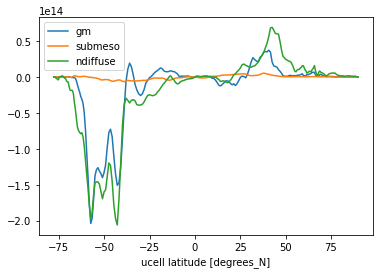

In [28]:
temp_yflux_gm_on_nrho.sum('grid_xt_ocean').sum('neutral').plot(label = 'gm')
temp_yflux_submeso_on_nrho.sum('grid_xt_ocean').sum('neutral').plot(label = 'submeso')
temp_yflux_ndiffuse_on_nrho.sum('grid_xt_ocean').sum('neutral').plot(label = 'ndiffuse')
plt.legend()

## Combined Plot (new grouping)

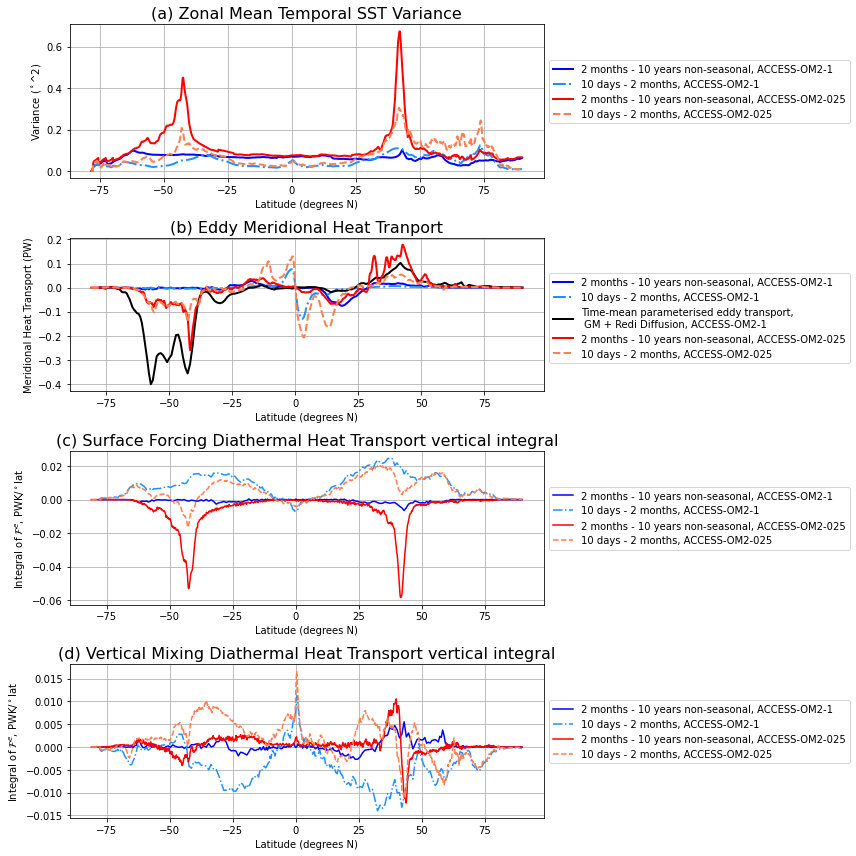

In [35]:
fig = plt.figure(figsize = (12,12))
plt.subplot(4,1,1)

(var_lt_1).plot(label='2 months - 10 years non-seasonal, ACCESS-OM2-1',linewidth=2, color = 'blue',linestyle = '-')
(var_2mo_1).plot(label='10 days - 2 months, ACCESS-OM2-1',linewidth=2, color = 'dodgerblue',linestyle = '-.')
(var_lt_025).plot(label='2 months - 10 years non-seasonal, ACCESS-OM2-025',linewidth=2, color = 'red',linestyle = '-')
(var_2mo_025).plot(label='10 days - 2 months, ACCESS-OM2-025',linewidth=2, color = 'coral',linestyle = '--')

plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('(a) Zonal Mean Temporal SST Variance', fontsize = 16)
plt.ylabel('Variance ($^\circ$^2)')
plt.grid()

plt.subplot(4,1,2)
(Hf_lt_1.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='2 months - 10 years non-seasonal, ACCESS-OM2-1',linewidth=2, color = 'blue',linestyle = '-')
(Hf_TIWs_1.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='10 days - 2 months, ACCESS-OM2-1',linewidth=2, color = 'dodgerblue',linestyle = '-.')
((temp_yflux_gm_on_nrho+temp_yflux_ndiffuse_on_nrho)/1.e15).sum('grid_xt_ocean').sum('neutral').plot(label='Time-mean parameterised eddy transport,\n GM + Redi Diffusion, ACCESS-OM2-1',linewidth=2, color = 'k',linestyle = '-')

(Hf_lt_025.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='2 months - 10 years non-seasonal, ACCESS-OM2-025',linewidth=2, color = 'red',linestyle = '-')
(Hf_TIWs_025.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='10 days - 2 months, ACCESS-OM2-025',linewidth=2, color = 'coral',linestyle = '--')


plt.ylabel('Meridional Heat Transport (PW)')
plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('(b) Eddy Meridional Heat Tranport', fontsize = 16)
plt.grid()

plt.subplot(4,1,3)
(SF_lt_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = '2 months - 10 years non-seasonal, ACCESS-OM2-1', color = 'blue',linestyle = '-')
(SF_TIWs_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = '10 days - 2 months, ACCESS-OM2-1', color = 'dodgerblue',linestyle = '-.')

(SF_lt_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = '2 months - 10 years non-seasonal, ACCESS-OM2-025', color = 'red',linestyle = '-')
(SF_TIWs_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = '10 days - 2 months, ACCESS-OM2-025', color = 'coral',linestyle = '--')

plt.ylabel('Integral of $\mathcal{F}^e$, PWK/$^\circ$lat')
plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('(c) Surface Forcing Diathermal Heat Transport vertical integral', fontsize = 16)
plt.grid()

plt.subplot(4,1,4)

(MX_lt_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = '2 months - 10 years non-seasonal, ACCESS-OM2-1', color = 'blue',linestyle = '-')
(MX_TIWs_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = '10 days - 2 months, ACCESS-OM2-1', color = 'dodgerblue',linestyle = '-.')

(MX_lt_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = '2 months - 10 years non-seasonal, ACCESS-OM2-025', color = 'red',linestyle = '-')
(MX_TIWs_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = '10 days - 2 months, ACCESS-OM2-025', color = 'coral',linestyle = '--')

plt.ylabel('Integral of $\mathcal{F}^e$, PWK/$^\circ$lat')
plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('(d) Vertical Mixing Diathermal Heat Transport vertical integral', fontsize = 16)

# plt.text(-75,0.04,'Variance creation',fontsize = 14)
# plt.text(-75,-0.04,'Variance destruction',fontsize = 14)
plt.grid()

plt.tight_layout()
plt.savefig('comparison_resolutions_updated.png',dpi = 200)

## Combined Plot (original)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encounte

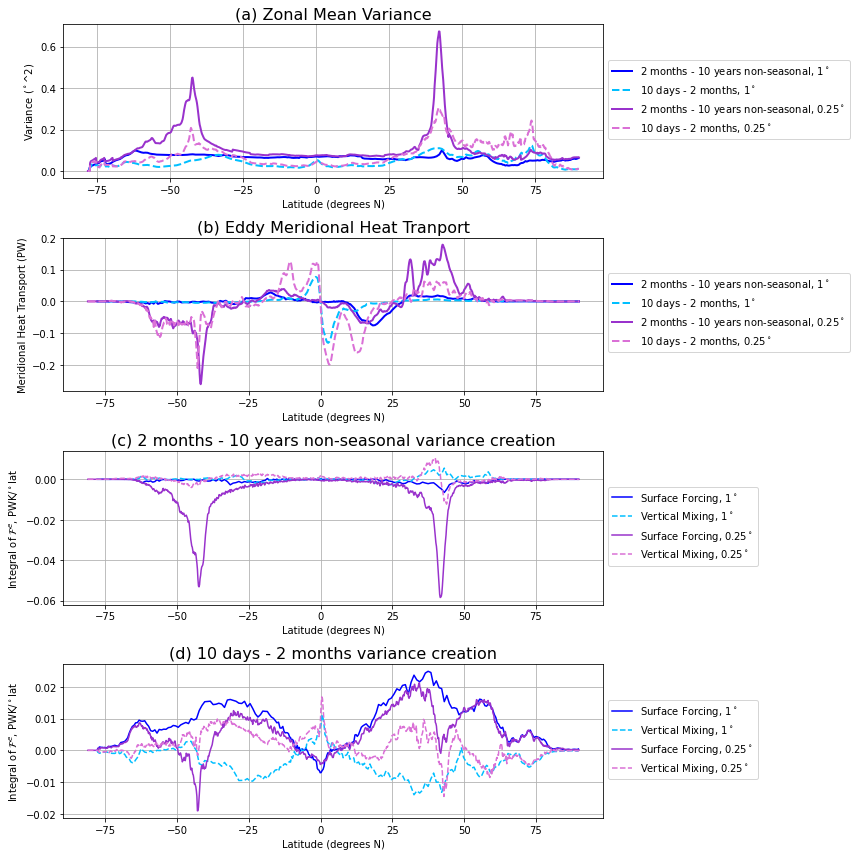

In [12]:
fig = plt.figure(figsize = (12,12))
plt.subplot(4,1,1)

(var_lt_1).plot(label='2 months - 10 years non-seasonal, 1$^\circ$',linewidth=2, color = 'blue',linestyle = '-')
(var_2mo_1).plot(label='10 days - 2 months, 1$^\circ$',linewidth=2, color = 'deepskyblue',linestyle = '--')
(var_lt_025).plot(label='2 months - 10 years non-seasonal, 0.25$^\circ$',linewidth=2, color = 'darkorchid',linestyle = '-')
(var_2mo_025).plot(label='10 days - 2 months, 0.25$^\circ$',linewidth=2, color = 'orchid',linestyle = '--')

plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('(a) Zonal Mean Variance', fontsize = 16)
plt.ylabel('Variance ($^\circ$^2)')
plt.grid()

plt.subplot(4,1,2)
(Hf_lt_1.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='2 months - 10 years non-seasonal, 1$^\circ$',linewidth=2, color = 'blue',linestyle = '-')
(Hf_TIWs_1.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='10 days - 2 months, 1$^\circ$',linewidth=2, color = 'deepskyblue',linestyle = '--')
(Hf_lt_025.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='2 months - 10 years non-seasonal, 0.25$^\circ$',linewidth=2, color = 'darkorchid',linestyle = '-')
(Hf_TIWs_025.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='10 days - 2 months, 0.25$^\circ$',linewidth=2, color = 'orchid',linestyle = '--')

plt.ylabel('Meridional Heat Transport (PW)')
plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('(b) Eddy Meridional Heat Tranport', fontsize = 16)
plt.grid()

plt.subplot(4,1,3)

(SF_lt_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = 'Surface Forcing, 1$^\circ$', color = 'blue',linestyle = '-')
(MX_lt_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = 'Vertical Mixing, 1$^\circ$', color = 'deepskyblue',linestyle = '--')
(SF_lt_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'Surface Forcing, 0.25$^\circ$', color = 'darkorchid',linestyle = '-')
(MX_lt_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'Vertical Mixing, 0.25$^\circ$', color = 'orchid',linestyle = '--')

plt.ylabel('Integral of $\mathcal{F}^e$, PWK/$^\circ$lat')
plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('(c) 2 months - 10 years non-seasonal variance creation', fontsize = 16)
plt.grid()

plt.subplot(4,1,4)

(SF_TIWs_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = 'Surface Forcing, 1$^\circ$', color = 'blue',linestyle = '-')
(MX_TIWs_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = 'Vertical Mixing, 1$^\circ$', color = 'deepskyblue',linestyle = '--')
(SF_TIWs_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'Surface Forcing, 0.25$^\circ$', color = 'darkorchid',linestyle = '-')
(MX_TIWs_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'Vertical Mixing, 0.25$^\circ$', color = 'orchid',linestyle = '--')

plt.ylabel('Integral of $\mathcal{F}^e$, PWK/$^\circ$lat')
plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('(d) 10 days - 2 months variance creation', fontsize = 16)

# plt.text(-75,0.04,'Variance creation',fontsize = 14)
# plt.text(-75,-0.04,'Variance destruction',fontsize = 14)
plt.grid()

plt.tight_layout()
plt.savefig('comparison_resolutions.png',dpi = 200)

## compare diurnal cycles

In [11]:
path = '/scratch/e14/cy8964/temp/1deg_101/'
path2 = '/scratch/e14/cy8964/temp/1deg_102_10yr/'
True_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/True_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
SF_1day = xr.open_dataarray(path+'1daily_mean_1year_means_SF_1day.nc')
MX_1day= xr.open_dataarray(path+'1daily_mean_1year_means_MX_1day.nc')

SF_diurnal_1 = True_1year_means_1.SF - SF_1day
MX_diurnal_1 = True_1year_means_1.MX - MX_1day


In [17]:
xch = 1440#2*288
ych = 1080#2*216

True_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/True_1year_means_corrected.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/Mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Twomo_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/2mo_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Tenday_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/10day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Oneday_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/1day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

In [18]:
SF_diurnal_025 = True_1year_means.SF - Oneday_mean_1year_means.SF
MX_diurnal_025 = True_1year_means.MX - Oneday_mean_1year_means.MX


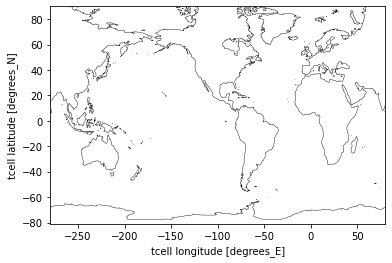

In [13]:
mask = (fgrd.ht.where(fgrd.ht>0)*0+1).fillna(0)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


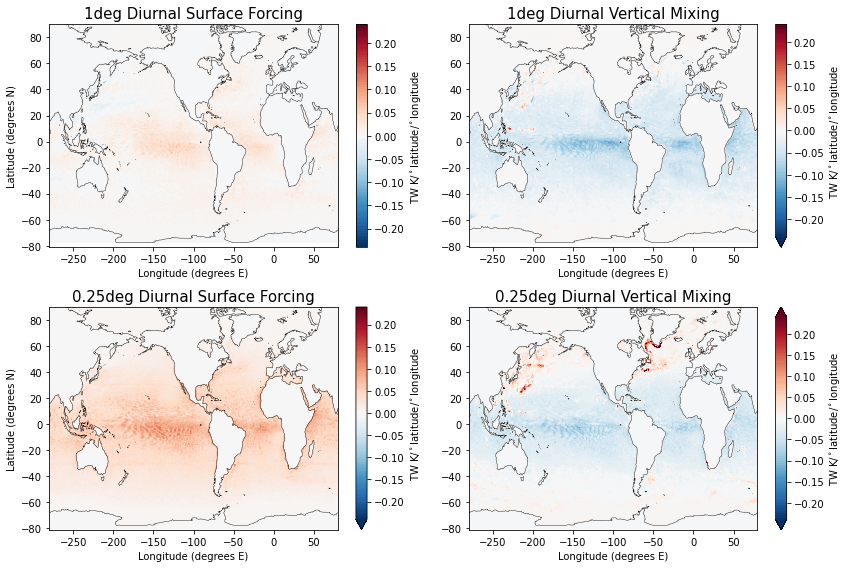

2022-06-10 16:52:17,818 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:17,825 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,110 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,114 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,192 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,284 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,374 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,553 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,643 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,663 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,745 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,828 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,920 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,995 - distributed.

In [26]:
fig = plt.figure(figsize=(12,8),facecolor='w')
cmap = 'RdBu_r'


## Plot data from Diurnal

SFcbar = np.arange(-0.24,0.245,0.005)
MXcbar = np.arange(-0.24,0.245,0.005)

plt.subplot(2,2,1)
((SF_diurnal_1).sum('neutralrho_edges')/1.e12/dx1/dy1*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('1deg Diurnal Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('Longitude (degrees E)')


plt.subplot(2,2,2)
((MX_diurnal_1).sum('neutralrho_edges')/1.e12/dx1/dy1*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('1deg Diurnal Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('Longitude (degrees E)')


plt.subplot(2,2,3)
((SF_diurnal_025).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('0.25deg Diurnal Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('Longitude (degrees E)')


plt.subplot(2,2,4)
((MX_diurnal_025).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('0.25deg Diurnal Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('Longitude (degrees E)')


fig.tight_layout()

## note 1deg is currently missing some mixing terms!!!! 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


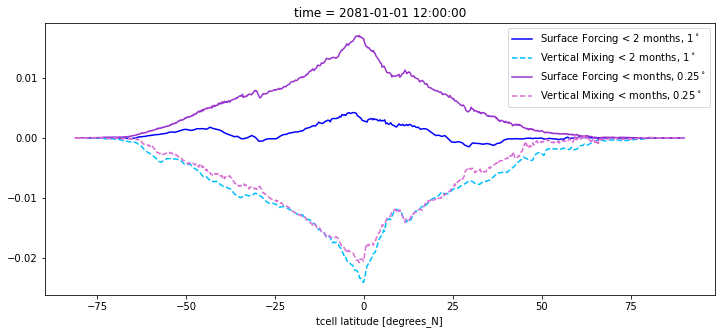

In [25]:
plt.figure(figsize = (12,5))
(SF_diurnal_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = 'Surface Forcing < 2 months, 1$^\circ$', color = 'blue',linestyle = '-')
(MX_diurnal_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = 'Vertical Mixing < 2 months, 1$^\circ$', color = 'deepskyblue',linestyle = '--')
(SF_diurnal_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'Surface Forcing < months, 0.25$^\circ$', color = 'darkorchid',linestyle = '-')
(MX_diurnal_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'Vertical Mixing < months, 0.25$^\circ$', color = 'orchid',linestyle = '--')
plt.legend()